In [12]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable
from torch.optim import Adam
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import csv
import seaborn as sns
from fastai import *
import fastai
fastai.__version__
from fastai.tabular import * 
from fastai.callbacks import *
from fastai.vision import *
import pickle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#import net
class ConvCaps2D(nn.Module):
    def __init__(self):
        super(ConvCaps2D, self).__init__()
        self.capsules = nn.ModuleList([nn.Conv2d(in_channels = 256, out_channels = 8, kernel_size=(1,4), stride=2)
                                       for _ in range(32)])
        
    def squash(self, tensor, dim=-1):
        norm = (tensor**2).sum(dim=dim, keepdim = True) 
        scale = norm / (1 + norm)  
        return scale*tensor / torch.sqrt(norm)
        
    def forward(self, x):
        outputs = [capsule(x).view(x.size(0), 8, -1) for capsule in self.capsules] 
        outputs = torch.cat(outputs, dim = 2).permute(0, 2, 1)  
        return self.squash(outputs)

class Caps1D(nn.Module):
    def __init__(self):
        super(Caps1D, self).__init__()
        self.num_caps = 13
        self.num_iterations = 3
        self.W = nn.Parameter(torch.randn(13, 928, 8, 16))
        
    def softmax(self, x, dim = 1):
        transposed_input = x.transpose(dim, len(x.size()) - 1)
        softmaxed_output = F.softmax(transposed_input.contiguous().view(-1, transposed_input.size(-1)))
        return softmaxed_output.view(*transposed_input.size()).transpose(dim, len(x.size()) - 1)

    def squash(self, tensor, dim=-1):
        norm = (tensor**2).sum(dim=dim, keepdim = True) 
        scale = norm / (1 + norm)        
        return scale*tensor / torch.sqrt(norm)
   
    # Routing algorithm
    def forward(self, u):
        u_ji = torch.matmul(u[:, None, :, None, :], self.W)
        b = Variable(torch.zeros(u_ji.size()))
        for i in range(self.num_iterations):
            c = self.softmax(b, dim=2)
            v = self.squash((c * u_ji).sum(dim=2, keepdim=True)) 
            if i != self.num_iterations - 1:
                delta_b = (u_ji * v).sum(dim=-1, keepdim=True)
                b = b + delta_b
        v = v.squeeze()
        y=v.data.cpu().numpy()
        hook1=y[:,0:13,0:16]
        y = np.reshape(y,(len(y)*13,16))
        with open('test_16.csv', 'w') as outfile:
           writer=csv.writer(outfile, delimiter='\t')
           writer.writerows(y)
        classes = (v ** 2).sum(dim=-1) ** 0.5
        classes = F.softmax(classes) 
        hook=c.data.cpu().numpy()
        x=hook[:,0:13,0:928,-1,-1]
        x = np.reshape(x,(len(x)*13,928))
        with open('test.csv', 'w') as outfile:
           writer=csv.writer(outfile, delimiter='\t')
           writer.writerows(x)
        return classes

class CapsNet(nn.Module):
    def __init__(self):
        super(CapsNet, self).__init__()
        self.fc1 = nn.Linear(2000, 64)
        self.dropout1 = nn.Dropout(p=0.5)
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 256, kernel_size = (1,4), stride = 1)
        
        self.primaryCaps = ConvCaps2D()
        self.digitCaps = Caps1D()
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.conv1(x))
        x = self.primaryCaps(x)
        x = self.digitCaps(x)
        return x

net = pickle.load(open('net_no_integration_20epochs.sav', 'rb'))

(7895, 2000)
0
(350, 1, 1, 2000)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


F1 score: 0.997143
Accuracy score: 0.997143
CLASS 0


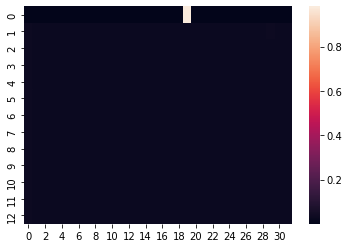

1
(2293, 1, 1, 2000)


In [ ]:
'''
compute the coupling coefficients for every cell type when all genes are used.
This is needed to retrieve the main primary-type capsule connection and to get
a baseline result to compare results later.
'''
#array of expressed genes, in this case we use the whole gene expression data
genes = np.arange(2000)
#genes=[254, 268, 269, 1072]
label=label=np.genfromtxt('data/cell_type_no_onlyrna.csv',delimiter=',').astype('int64')

scale_data_all = pd.read_csv('data/rna_scaled.csv', index_col=0)
scale_data_all = scale_data_all.transpose()
colnames=scale_data_all.columns.values
scale_data=scale_data_all.copy()
scale_data.loc[:, np.setdiff1d(colnames,colnames[genes])]=0
bn_actns = np.array(scale_data)

coup_gene_all=np.zeros(shape=(1,32))
#for every class
#RANGE 13
coup_gene=np.zeros(shape=(1,32))
for l in range(13):
    print(l)
    #all rows with class l
    n=np.where(label==l)
    #n[0]=all rows with class l -> all bn:actns with label l
    d=bn_actns[n[0],:]
    d=d.reshape(len(d),1, 2000)
    d=np.expand_dims(d.astype('float32'), 1)
    print(d.shape)
    #feed in expression for all cells of this class; those go through the net then
    #output=type capsules (13x16 for each single cell)
    #size(singlecellsx13x928)
    net(Variable(torch.from_numpy(d)))
    
    #coupling coefficients
    test_cell=pd.read_csv('test.csv', sep='\t',header=None)

    #test_cell= pd.read_csv("test.csv", sep='\t',header=None)
    #size 790*13 x 928 (test_size=790 cells)
    test_cell=test_cell.to_numpy()
    
    #shape test_cell=(singlecells*13, 928)
    test_cell_reformated=np.zeros(shape=(test_cell.shape[0],32))
    
    #print(test_cell_reformated.shape)
    #shape test_cell_reformated=(singlecells*13, 32)
    #test_cell[0]=928
    #range (singlecells*13)
    for i in range(np.shape(test_cell)[0]):
        k=0
        #compresses 928 into 32
        #print(np.sum(test_cell[i]))
        for j in range(32):
            #takes max of the 29 places
            #original uses np.amax
            test_cell_reformated[i,j]= np.sum(test_cell[i,k:(j+1)*29])
            k=(j+1)*29+1
    #shape (#cells*13, 32)
    #-> test_cell_reformated = 32 primary caps for every cell*13
    #average for cell type: new shape= (13*32)
   
    avg_coup=np.zeros(shape=(1,32))
    for i in range(13):
        #s=size 32
        #first entry for class i
        s=test_cell_reformated[i,:]
        for k in range(n[0].shape[0]):
            #add every cell-result for this class
            s=np.add(s,test_cell_reformated[(i+13*k),:])
        avg_s=s/n[0].shape[0]
        #size avg_s =(32,)
        avg_coup=np.vstack((avg_coup,avg_s))
        #final size avg_coup = (14, 32)
    #remove first row with 0s
    avg_coup=avg_coup[1:14,:]
    print("CLASS", l)
    ax = sns.heatmap(avg_coup)
    plt.show()
    #final size avg_coup (13, 32)
    coup_gene=np.vstack((coup_gene,avg_coup))
#remove first row with 0s
coup_gene=coup_gene[1:170,:]
#coup_gene = shape(13*13,32)
coup_gene_all=np.vstack((coup_gene_all,coup_gene))
#remove first row with 0s
coup_gene_all=coup_gene_all[1:]
print("CC for all genes, for all cell types", coup_gene_all.shape)
np.savetxt('results/cc_all_cells.csv',coup_gene_all,delimiter=',')


average_coup_for_gene=np.zeros(shape=(1,32))
#for every class average coupling coefficients
for i in range(13):
        u=coup_gene_all[i,:]
        for f in range(13):
            u=np.add(u,coup_gene_all[(i+13*f),:])
        avg_u=u/13
        average_coup_for_gene=np.vstack((average_coup_for_gene,avg_u))
        #final size avg_coup = (14, 32)
#remove first row with 0s
average_coup_for_gene=average_coup_for_gene[1:14,:]
print("Averaged CC for all cell types", average_coup_for_gene.shape)
np.savetxt('results/cc_all_cells_compressed.csv',average_coup_for_gene,delimiter=',')

(169, 32)
[[6.007687e-04 4.904729e-04 1.100339e-03 5.286875e-04 ... 5.749872e-04 6.331271e-04 7.436781e-04 8.808742e-04]
 [2.194819e-04 1.863839e-04 1.441200e-04 1.185298e-04 ... 1.602242e-04 9.944930e-01 2.214857e-04 2.548042e-04]
 [1.808554e-03 2.210323e-03 1.451768e-03 2.316363e-03 ... 9.381534e-01 1.626352e-03 2.744863e-03 2.076317e-03]
 [1.059494e-03 1.315447e-03 9.503132e-04 7.621987e-04 ... 9.505509e-04 1.157402e-03 4.633889e-04 2.114342e-03]
 ...
 [1.659579e-03 1.612129e-03 1.546676e-03 1.637366e-03 ... 1.571772e-03 1.464333e-03 1.318932e-03 1.426260e-03]
 [4.074877e-04 4.076252e-04 2.596656e-04 9.909650e-01 ... 2.556207e-04 2.755795e-04 2.786677e-04 3.063081e-04]
 [1.654908e-03 2.080483e-03 9.619215e-01 1.690136e-03 ... 1.558342e-03 5.532161e-03 2.247718e-03 1.205986e-03]
 [2.147845e-03 4.930671e-03 2.603520e-03 8.020170e-03 ... 3.439667e-02 1.983813e-03 2.363680e-03 2.795661e-03]]


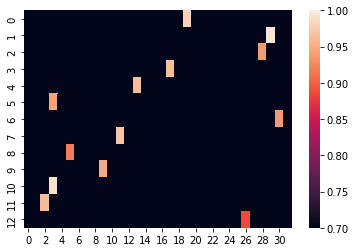

In [25]:
'''
Display of the averaged coupling coefficients for all cell types.
'''
coup_gene_all = np.genfromtxt('results/cc_all_cells.csv', delimiter=",")
print(coup_gene_all.shape)

average_coup_for_gene=np.zeros(shape=(1,32))
#for every class average coupling coefficients
for i in range(13):
        u=coup_gene_all[13*i+i,:]
        average_coup_for_gene=np.vstack((average_coup_for_gene, u))
average_coup_for_gene=average_coup_for_gene[1:14,:]
print(average_coup_for_gene)
ax = sns.heatmap(average_coup_for_gene, vmin = 0.7, vmax = 1)
plt.show()

In [4]:
'''
Function to retrieve the main coupling coefficient for each cell type using all 
coupling coefficients (computed above)
'''
def get_prim_caps(coupling_coefficients):
  primcaps=[]
  for i in range(13):
    prim=np.where(coupling_coefficients[13*i+i] == np.amax(coupling_coefficients[13*i+i]))
    primcaps.append(prim[0][0])
  return primcaps

'''
Function to retrieve the main #amount coupling coefficients for each cell type
'''
def get_multiple_prim_caps(coupling_coefficients, amount):
  primcaps=[]
  for i in range(13):
    prim = coupling_coefficients[13*i+i].argsort()[-amount:][::-1]
    primcaps.append(prim)
  return primcaps

In [5]:
'''
Genetic algorithm
individuals: population size
genes: amount of genes in total 
expressed: amount of genes in the genome (=amount of expressed gene expressions)
mating_percentage: percentage how many individuals mate everx generation
mutation_rate: percentage how many genes are mutated 
crossover_rate: percentage of how often parents' chromosomes overlapp
termination: coupling coefficient at which the algorithm stops
pool: if the genes are limited (for example when the gene pool got smaller), array of all genes
'''
class Genetic_Algorithm:
  def __init__(self,individuals, genes, expressed, mating_percentage, mutation_rate, crossover_rate, termination, pool):
    self.individuals=individuals
    self.genes=genes
    self.expressed=expressed
    self.mating_percentage=mating_percentage
    self.mutation_rate=mutation_rate
    self.crossover_rate=crossover_rate
    self.termination = termination
    self.term = False
    self.pool=pool.astype(int)

    #initializing population
    population=np.ones(shape=(1,self.expressed))
    for i in range(self.individuals):
      #indi= np.sort(np.random.choice(self.genes, size=self.expressed, replace=False))
      #individual=random genome of size self.expressed with genes from self.pool
      indi= np.sort(random.choices(self.pool, k=expressed))
      print(indi)
      population=np.vstack((population,indi))
    self.population=population[1:].astype(int)
    
  

  #not every individual is mating every generation
  def mating(self):
    number_mating= int(self.individuals*self.mating_percentage)
    #mates=np.random.randint(self.individuals, size=number_mating)
    #choose randomly which individuals mate
    mates=np.random.choice(self.individuals, size=number_mating, replace=False)
    #print(self.population)
    #print(len(self.population))
    #print(mates)
    number_couples=int(number_mating/2)
    #mating: crossover and mutation + adding child to population
    for i in range(number_couples):
      child=self.crossover(self.population[mates[i]],self.population[mates[number_couples+i]])
      #print(child)
      child=self.mutation(child)
      #print(child)
      child=np.sort(child)
      #print(i)
      #print(number_couples+i)
      #print(mates[i])
      #print(mates[number_couples+i])
      self.population=np.vstack((self.population, child)).astype(int)
    print(self.population.shape)



  def crossover(self, parent1, parent2):
    #how often chromosomes overlap (= number of cuts of chromosomes)
    cuts=random.randint(0, int(self.expressed*self.crossover_rate))
    #place where the chromosomes are cut
    places_cuts=np.random.choice(self.expressed, size=cuts, replace=False)
    places_cuts = np.concatenate((places_cuts, [0, self.expressed]))
    places_cuts=np.sort(places_cuts)
    #print(parent1, parent2)
    #print(cuts)
    #print(places_cuts)
    child=[]
    for i in range(cuts+1):
      #randomly choose if next sequence is from parent 0 or parent 1
      parent= random.randint(0,1)
      #print("parent ", parent)
      if parent==0:
        #print(parent1[places_cuts[i]:places_cuts[i+1]])
        child= np.concatenate((child, parent1[places_cuts[i]:places_cuts[i+1]]))
      if parent==1:
        #print(parent2[places_cuts[i]:places_cuts[i+1]])
        child= np.concatenate((child, parent2[places_cuts[i]:places_cuts[i+1]]))
    return child

  def mutation(self, child):
    #how many mutations
    mutations= int(self.expressed*self.mutation_rate)
    for m in range(mutations):
      #random index 
      index=random.randint(0, int(self.expressed-1))
      #new value 
      #child[index]=random.randint(0, int(self.genes - 1))
      child[index]= random.choices(self.pool)[0]
    return child
  
  #take population and calculate surviving individuals
  def selection(self, coupling_coefficients):
    #coupling coefficients of the whole population
    coupling_coefficients=np.array(coupling_coefficients)
    #add the coloumns to get average cc for each individual
    added_cc = np.sum(coupling_coefficients, axis = 1)
    print("coupling_coefficients added", added_cc)
    rank=[]
    '''
    for p in range(self.individuals):
      print(p)
      #fitness_score=self.fitness(coupling_coefficients[p])
      rank.append(fitness_score)
    '''
    #rank fitness
    #sort the individuals by coupling coefficient and get the indexes of the highest scoring individuals
    selected=sorted(range(len(added_cc)),key=added_cc.__getitem__)
    ##print("rank", selected)
    print("selected", selected[-self.individuals:])
    #the highest ranked individuals are left in population
    self.population=self.population[selected[-self.individuals:]]
    ##print("population", self.population)
    return coupling_coefficients[selected[-self.individuals:]].tolist()
    
  '''
  #coupling_coefficient  Array of size shape=(13,32)
  def fitness(self, coupling_coefficient):
    all_max_coup=[]
    #print(coupling_coefficient.shape)
    for i in range(13):
      all_max_coup.append(np.amax(coupling_coefficient[i]))
    return np.average(all_max_coup)
  '''
  #checks if termination criterion is fulfilled
  def terminating(self, coupling_coefficients):
        #print("TERMINATION",coupling_coefficients)
        if np.amax(coupling_coefficients) >= self.termination:
            self.term = True

In [10]:
'''
calculates and stores coupling coefficients for a cell type
celltype= cell type (e.g. 0 for b cell)
cc= target coupling coefficient (e.g. 19 for b cell)
'''
class Coupling():
  def __init__(self, celltype, cc):
      #gene expression
      self.scale_data_all = pd.read_csv('data/rna_scaled.csv', index_col=0)
      self.scale_data_all = self.scale_data_all.transpose()
      self.colnames = self.scale_data_all.columns.values
      #label
      self.label = label=np.genfromtxt('data/cell_type_no_onlyrna.csv',delimiter=',').astype('int64')
      self.coup_gene_all = np.zeros(shape=(1,32))
      
      self.coefficient=[]
      self.acc=[]
      
      self.celltype=celltype
      self.cc=cc

  #calculate target coupling coefficient for a given gene set and append it to
  #the list of self.coefficient
  def coupling_coefficients(self, genes):
      scale_data=self.scale_data_all.copy()
      #get gene expression data for the given gene set
      scale_data.loc[:, np.setdiff1d(self.colnames,self.colnames[genes])]=0
      bn_actns = np.array(scale_data)
      coup_gene=np.zeros(shape=(1,32))
      #all rows with given cell type
      n=np.where(self.label==self.celltype)
      #n[0]=all rows with cell type -> all bn:actns with cell type
      d=bn_actns[n[0],:]
      d=d.reshape(len(d),1, 2000)
      d=np.expand_dims(d.astype('float32'), 1)

      #feed in expression for all cells of this class; those go through the net then
      #output=type capsules (13x16 for each single cell)
      #size(singlecellsx13x928)
      net(Variable(torch.from_numpy(d)))

      #used to calculate corresponding accuracy 
      with torch.no_grad():
        gene = torch.from_numpy(d)
        class_label=np.full((len(n[0])), self.celltype)
        gene_label = torch.LongTensor(class_label)
        inputs, labels = Variable(gene), Variable(gene_label)
        # Generate prediction
        prediction = net(inputs)
        #print(prediction)
        # Predicted class value using argmax
        predicted_class =prediction.argmax(dim=1, keepdim=True)
        print('F1 score: %f' % f1_score(labels, predicted_class, average='micro'))
        print('Accuracy score: %f' % accuracy_score(labels, predicted_class))
        self.acc.append(accuracy_score(labels, predicted_class))

      #coupling coefficients retrieved from forward pass
      test_cell=pd.read_csv('test.csv', sep='\t',header=None)
      #size 790*13 x 928 (test_size=790 cells)
      test_cell=test_cell.to_numpy()

      #test_cell=log(test_cell/(1-test_cell))
      #print(np.sum(test_cell[0]))
      #print((test_cell[0]))
      #print(test_cell.shape)

      #shape test_cell=(singlecells*13, 928)
      test_cell_reformated=np.zeros(shape=(test_cell.shape[0],32))

      #size of test_cell[0]=928
      #summing neurons of primary capsules
      #range (singlecells*13)
      for i in range(np.shape(test_cell)[0]):
        k=0
        #compresses 928 into 32
        #print(np.sum(test_cell[i]))
        for j in range(32):
            #takes max of the 29 places
            #original uses np.amax
            test_cell_reformated[i,j]= np.sum(test_cell[i,k:(j+1)*29])
            k=(j+1)*29+1
      #shape (#cells*13, 32)
      #-> test_cell_reformated = 32 primary caps for every cell*13

      #average for cell type: new shape= (13*32)
      avg_coup=np.zeros(shape=(1,32))
      for i in range(13):
        #s=size 32
        #first entry for class i
        s=test_cell_reformated[i,:]
        #print("s ", s.shape)
        #old: for k in range(13):
        for k in range(n[0].shape[0]):
            #add every cell-result for this class
            s=np.add(s,test_cell_reformated[(i+13*k),:])
        #print("s ", s.shape)
        avg_s=s/n[0].shape[0]
        #size avg_s =(32,)
        #print("avg_s ",avg_s.shape)
        avg_coup=np.vstack((avg_coup,avg_s))
        #print("avg_coup ",avg_coup.shape)
        #final size avg_coup = (14, 32)
      #print("COUP",avg_coup)
      #print(avg_coup.shape)
      #remove first row with 0s
      avg_coup=avg_coup[1:14,:]

      self.coup_gene_all = avg_coup
      
      #print("CELLTYPE", k)
      #print(coupling_k[k])
      #print(index)

      #get all coupling coefficients for type capsule of the cell type
      coupling_class=self.coup_gene_all[self.celltype]
      #get target coupling coefficient
      coefficient=coupling_class[self.cc]
      print("coefficient", coefficient)
      #add target coupling coefficient to list
      self.coefficient.append(coefficient)
 

In [14]:
def run(celltype, population, coupling, max_generations, expressed):
  generation=0
  print("GENERATION", generation) 
  population.mating()
  np.savetxt(f"cell{celltype}_{generation}population_{expressed}expressed.csv",population.population,delimiter=',')  
  #CC for all individuals
  for person in range(population.population.shape[0]):
      print("Individual", person)
      coupling.coupling_coefficients(population.population[person])
  print(coupling.coefficient)
  #np.savetxt(f"{experiment}_{generation}coup_gene_all_genetic.csv",coupling.coup_gene_all,delimiter=',')
  np.savetxt(f"cell{celltype}_{generation}coefficient_{expressed}expressed.csv",coupling.coefficient,delimiter=',') 
  #np.savetxt(f"{experiment}_{generation}acc.csv",coupling.acc,delimiter=',') 
  population.terminating(coupling.coefficient)
  coupling.coefficient = population.selection(coupling.coefficient)
  generation = generation+1

  while population.term == False and generation <= max_generations:
    print("GENERATION", generation) 
    population.mating()
    np.savetxt(f"cell{celltype}_{generation}population_{expressed}expressed.csv",population.population,delimiter=',')  
    #CC only for children
    for person in range(population.population.shape[0]-population.individuals):
      print("Individual", person)

      print("child", population.population[person+population.individuals])
      coupling.coupling_coefficients(population.population[person+population.individuals])
    print(coupling.coefficient)
    #np.savetxt(f"{experiment}_{generation}coup_gene_all_genetic.csv",coupling.coup_gene_all,delimiter=',')
    np.savetxt(f"cell{celltype}_{generation}coefficient_{expressed}expressed.csv",coupling.coefficient,delimiter=',') 
    #np.savetxt(f"{experiment}_{generation}acc.csv",coupling.acc,delimiter=',') 
    population.terminating(coupling.coefficient)
    coupling.coefficient =  population.selection(coupling.coefficient)
    generation = generation+1
  return population, coupling


In [18]:
celltype=8
#get the target cc
caps=get_multiple_prim_caps(np.genfromtxt('results/cc_all_cells.csv', delimiter=","),1)[celltype]
coupling=Coupling(celltype, caps)
expressed_genes=100
population=Genetic_Algorithm(individuals=50, genes=2000, expressed=expressed_genes,mating_percentage=0.6, mutation_rate=0.02,crossover_rate=0.2, termination=0.8, pool=np.arange(2000))
#number of generations the algorithm will run
max_generations =40
#first run with 100 expressed genes
population_new, coupling_new = run(celltype, population, coupling, max_generations, expressed_genes)

#getting smaller
max_generations =40
expressed_genes=10
gene_pool = np.unique(population_new.population)
print("Gene Pool", gene_pool)
population_2=Genetic_Algorithm(individuals=50, genes=2000, expressed=expressed_genes,mating_percentage=0.6, mutation_rate=0.02, crossover_rate=0.2, termination=1, pool=gene_pool)
coupling_2=Coupling(celltype, caps)
#second run with 10 expressed genes; the gene pool is the final gene pool from the first run
population_smaller, coupling_smaller= run(celltype, population_2, coupling_2, max_generations, expressed_genes)

[   2   88  111  136 ... 1911 1931 1947 1988]
[  10   45   60   76 ... 1958 1978 1990 1996]
[  19   23   51   59 ... 1926 1935 1944 1992]
[   2   22   79   86 ... 1972 1979 1979 1986]
[  29   85   96  120 ... 1871 1941 1973 1988]
[   1   11   12   13 ... 1946 1947 1955 1982]
[   3   10   14   52 ... 1927 1941 1966 1977]
[  54  102  106  128 ... 1963 1966 1968 1980]
[   7    9   30   35 ... 1910 1918 1922 1924]
[   5   11   15   23 ... 1912 1918 1926 1962]
[   7   31   40   94 ... 1926 1931 1967 1984]
[  28   29  132  144 ... 1949 1961 1991 1996]
[  13   62   64   87 ... 1966 1996 1997 1999]
[  41   99  244  258 ... 1974 1982 1994 1999]
[  15   30   70  113 ... 1889 1902 1967 1980]
[  26   32   39   91 ... 1921 1938 1946 1964]
[  10   14   25   32 ... 1987 1988 1991 1997]
[  84   95  115  131 ... 1942 1951 1959 1977]
[  40   63  158  186 ... 1870 1947 1948 1962]
[  82   98  112  137 ... 1983 1991 1993 1999]
[  34   48   70   71 ... 1902 1918 1972 1973]
[   6   16   23   37 ... 1878 1896

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Streaming output truncated to the last 5000 lines.
coefficient [0.657866]
Individual 7
child [  52   71   85   88 ... 1946 1966 1968 1980]
F1 score: 0.864583
Accuracy score: 0.864583
coefficient [0.541013]
Individual 8
child [  34   48   84   85 ... 1906 1931 1972 1973]
F1 score: 0.875000
Accuracy score: 0.875000
coefficient [0.600249]
Individual 9
child [  29   84   95  111 ... 1918 1951 1959 1986]
F1 score: 0.906250
Accuracy score: 0.906250
coefficient [0.633664]
Individual 10
child [   2   26   70  120 ... 1911 1931 1947 1958]
F1 score: 0.875000
Accuracy score: 0.875000
coefficient [0.627918]
Individual 11
child [   2   26   70  120 ... 1911 1931 1947 1958]
F1 score: 0.854167
Accuracy score: 0.854167
coefficient [0.539396]
Individual 12
child [  29   85   90   96 ... 1932 1972 1973 1992]
F1 score: 0.916667
Accuracy score: 0.916667
coefficient [0.629725]
Individual 13
child [  52   71   85   88 ... 1870 1879 1972 1984]
F1 score: 0.937500
Accuracy score: 0.937500
coefficient [0.630218

In [26]:
#get coupling coefficient for a set of genes
#those are the marker genes for the b cell
ge=[268, 254, 269, 1072]
cell=0
caps=get_multiple_prim_caps(np.genfromtxt('results/cc_all_cells.csv', delimiter=","),1)[cell]
coupling=Coupling(cell, caps)

coupling.coupling_coefficients(ge)

(7895, 2000)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


F1 score: 0.991429
Accuracy score: 0.991429
coefficient [0.412648]
